# Comparison Graphic
Demonstrating the benefits of using co-design as compared to traditional gripper designs, and visualization of changes over time.

In [89]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml

### Model Selection

In [174]:
evolution_file = "../logs/sb3/population_evolution/grasp_object/2025-08-10_08-41-21/population_results.yaml"
#evolution_file = "../logs/sb3/population_evolution/grasp_objects/2025-08-10_08-41-21/population_results.yaml"
#evolution_file = "../logs/sb3/population_evolution/grasp_pot/2025-08-10_08-41-21/population_results.yaml"
with open(evolution_file, 'r') as file:
    evolution_data = yaml.unsafe_load(file)

manual_file = "logs/sb3/Grasp-Object/2025-08-08_21-46-42/history.yaml"
manual_data = {"generations": [0, 3, 6, 9, 12, 15, 18, 21, 24, 27], "fitness": [129, 201, 257, 287, 301, 315, 372, 411, 557, 583]}

### Data Analysis

In [175]:
# Find the top agent
agents = {agent["id"]: agent for agent in evolution_data['agents']}
top_agent = None
top_agent_score = -np.inf
for agent_id, agent in agents.items():
    if agent["best_fitness"] > top_agent_score:
        top_agent_score = agent["best_fitness"]
        top_agent = agent

# Find performance history
performance_history = top_agent["fitness_history"].copy()
for generation, parent_id in top_agent["family_tree"]:
    parent_agent = evolution_data['agents'][parent_id]
    performance_history.update({gen: value for gen, value in parent_agent["fitness_history"].items() if gen < generation})

# Map each generation to an agent id
id_map = []
prev_gen = 1
for gen, parent_id in top_agent["family_tree"]:
    id_map += [parent_id for gen in range(prev_gen, gen+1)]
    prev_gen = gen+1
id_map += [top_agent["id"] for gen in range(prev_gen, top_agent["generation"]+2)] # Account for -1 offset and exclusive range

# Find the history of parameters 
length_history = np.zeros((len(id_map), 3))
width_history = np.zeros((len(id_map), 3))
rotation_history = np.zeros((len(id_map), 3))
for i, variant_id in enumerate(id_map):
    variant_params = np.array(agents[variant_id]["params"])
    length_history[i] = variant_params[:, 0]
    width_history[i] = variant_params[:, 1]
    rotation_history[i] = variant_params[:, 2]

# Find the manual agent 

### Graphic Creation

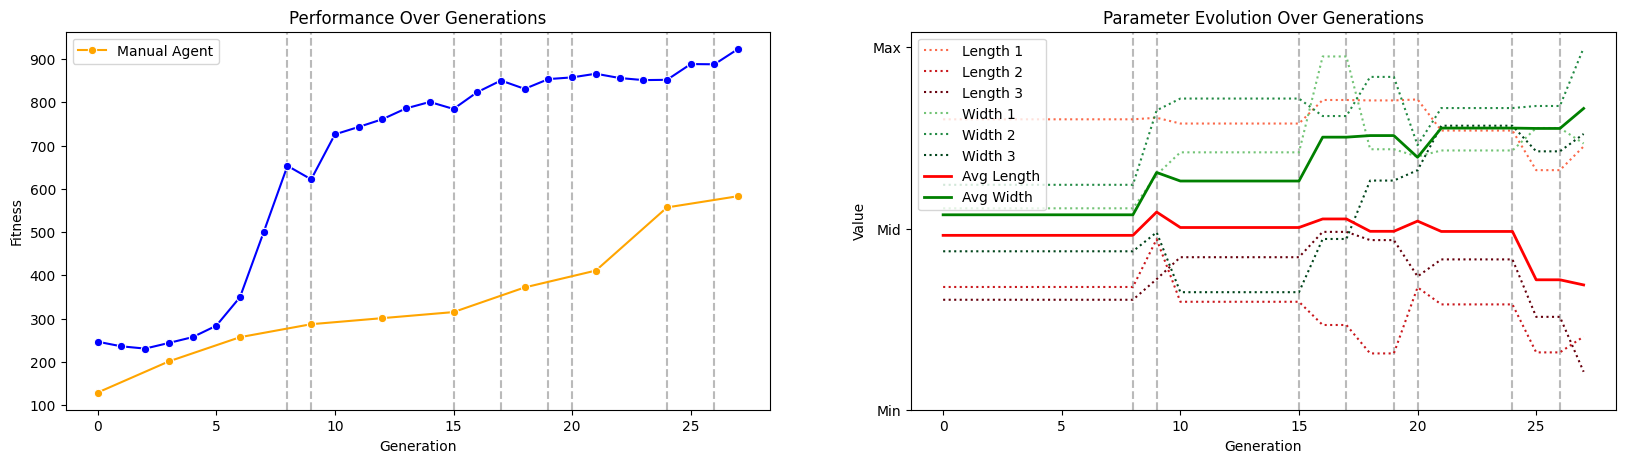

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fitness_ax = axes[0]
parameter_ax = axes[1]

# Prepare data for plotting
generations = [gen for gen in range(len(id_map))]
fitness = [agents[variant_id]["fitness_history"][gen] for gen, variant_id in enumerate(id_map)]

# Add a vertical line at each mutation
for gen, parent_id in top_agent["family_tree"]:
    fitness_ax.axvline(x=gen-1, color='darkgray', linestyle='--', alpha=0.8)
    parameter_ax.axvline(x=gen-1, color='darkgray', linestyle='--', alpha=0.8)

# Graph the lengths over time
MIN_LENGTH = 0.3
MAX_LENGTH = 2.0
normalized_lengths = (length_history - MIN_LENGTH) / (MAX_LENGTH - MIN_LENGTH)
for length in range(3):
    sns.lineplot(
        x=generations,
        y=normalized_lengths[:, length],
        label=f"Length {length+1}",
        ax=parameter_ax,
        linestyle=':',
        color=plt.cm.Reds(0.5 + 0.25*length)
    )

# Graph the widths over time
MIN_WIDTH = 0.1
MAX_WIDTH = 1.0
normalized_widths = (width_history - MIN_WIDTH) / (MAX_WIDTH - MIN_WIDTH)
for width in range(3):
    sns.lineplot(
        x=generations,
        y=normalized_widths[:, width], 
        label=f"Width {width+1}", 
        ax=parameter_ax, 
        linestyle=':',
        color=plt.cm.Greens(0.5 + 0.25*width)
    )

# Graph the rotations over time
MIN_ROTATION = 0
MAX_ROTATION = 2*np.pi
normalized_rotations = (rotation_history - MIN_ROTATION) / (MAX_ROTATION - MIN_ROTATION)
# for rotation in range(3):
#     sns.lineplot(
#         x=generations,
#         y=normalized_rotations[:, rotation], 
#         label=f"Rotation {rotation+1}", 
#         ax=parameter_ax, 
#         linestyle='--',
#         color=plt.cm.Blues(0.3 + 0.3*rotation)
#     )

# Add average lines for lengths and widths
avg_length = np.mean(normalized_lengths, axis=1)
avg_width = np.mean(normalized_widths, axis=1)
sns.lineplot(
    x=generations,
    y=avg_length, 
    label="Avg Length", 
    ax=parameter_ax, 
    color='red', 
    linewidth=2
)
sns.lineplot(
    x=generations,
    y=avg_width,
    label="Avg Width",
    ax=parameter_ax,
    color='green',
    linewidth=2
)


# Plot the performance history
sns.lineplot(x=generations, y=fitness, marker="o", ax=fitness_ax, label="Evolution", color='blue')
sns.lineplot(x=manual_data["generations"], y=manual_data["fitness"], marker="o", ax=fitness_ax, color='orange', label='Manual Agent')

fitness_ax.set_xlabel("Generation")
parameter_ax.set_xlabel("Generation")
fitness_ax.set_ylabel("Fitness")
parameter_ax.set_ylabel("Value")
fitness_ax.set_title("Performance Over Generations")
parameter_ax.set_title("Parameter Evolution Over Generations")

parameter_ax.set_yticks([0, 0.5, 1.0])
parameter_ax.set_yticklabels(['Min', 'Mid', 'Max'])

# Reserve space below for images
plt.subplots_adjust(bottom=0.25)  # Adjust as needed for image space

# # Add images along the bottom of the figure
# image_dir = "../diagrams/diagram_snapshots"
# image_files = sorted(os.listdir(image_dir))
# image_files = [f for f in image_files if f.endswith('.png')]
# image_count = len(image_files)
# image_width = 0.1  # Width of each image in the figure
# image_height = 0.1  # Height of each image in the figure
# for i, image_file in enumerate(image_files):
#     img_path = os.path.join(image_dir, image_file)
#     img = plt.imread(img_path)
#     ax = fig.add_axes([i * image_width, -0.10, image_width, image_height])  # Adjust y position as needed
#     # Resize image to fit the axes exactly
#     ax.imshow(img, aspect='equal', extent=[0, 1, 0, 1])
#     ax.axis('off')  # Hide axes for images

plt.show()